In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os

In [5]:
INPUT_DATA_DIRPATH = "data\\2.augmented"
OUTPUT_MODELS_DIRPATH = "models"


In [6]:
# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  INPUT_DATA_DIRPATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(16, 16),
  batch_size=32)

# Create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  INPUT_DATA_DIRPATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(16, 16),
  batch_size=32)

print(train_ds.class_names)

Found 33000 files belonging to 33 classes.
Using 6600 files for validation.
Found 33000 files belonging to 33 classes.
Using 26400 files for training.
['blank', 'corner_left_90', 'corner_right_90', 'crossing_marked_double_bottom', 'crossing_marked_double_diag_left', 'crossing_marked_double_diag_right', 'crossing_marked_double_left', 'crossing_marked_double_right', 'crossing_marked_double_top', 'crossing_marked_quad', 'crossing_marked_single_bottom_left', 'crossing_marked_single_bottom_right', 'crossing_marked_single_top_left', 'crossing_marked_single_top_right', 'crossing_marked_triple_bottom_left', 'crossing_marked_triple_bottom_right', 'crossing_marked_triple_top_left', 'crossing_marked_triple_top_right', 'crossing_unmarked', 'gap_end', 'gap_start', 'intersection_left_marked_both', 'intersection_left_marked_bottom', 'intersection_left_marked_top', 'intersection_left_unmarked', 'intersection_right_marked_both', 'intersection_right_marked_bottom', 'intersection_right_marked_top', 'inte

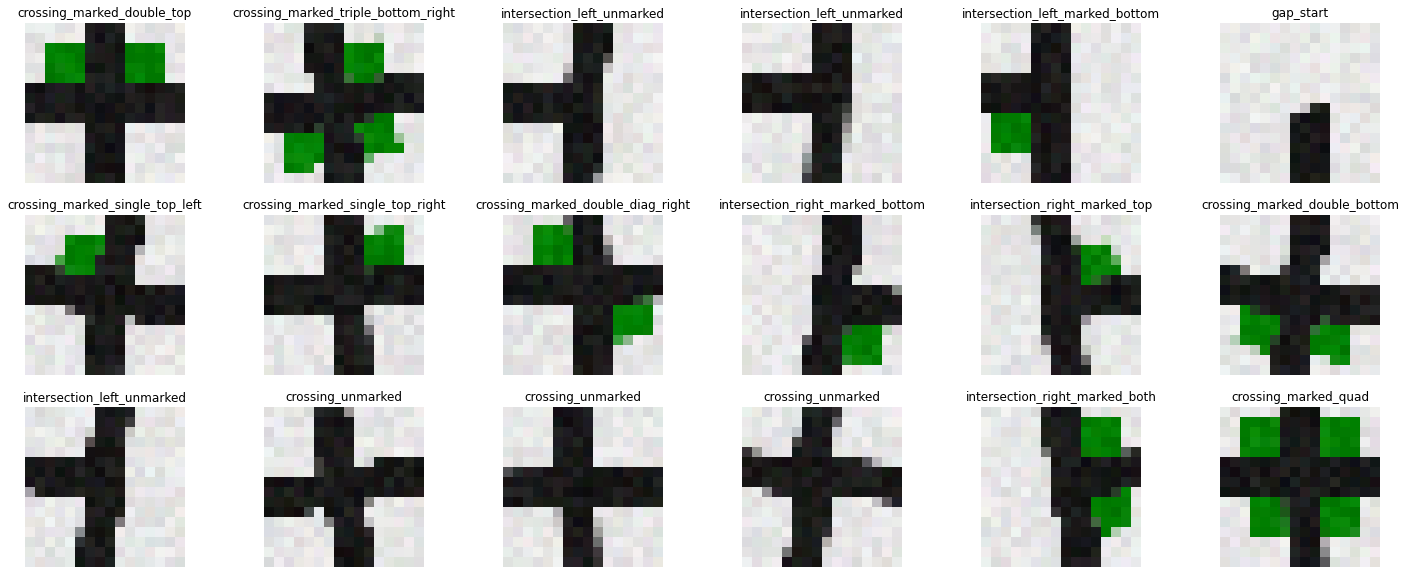

In [7]:
# Visualize input data
plt.figure(figsize=(25, 10))
for images, labels in train_ds.take(1):
  for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [8]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Build models

dense_layers = [1, 2, 3]
layer_sizes = [64, 128, 256]
dense_layer_sizes = [64, 128, 256]
conv_layers = [1, 2]
dropout_rates = [0.0, 0.2, 0.4]

with open(f"{OUTPUT_MODELS_DIRPATH}\\models.csv", "w") as f:
    f.write("name,dense_layers,nodes,dense_nodes,conv_layers,dropout,loss,accuracy\n")

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for dense_layer_size in dense_layer_sizes:
            for conv_layer in conv_layers:
                for dropout_rate in dropout_rates:
                    model_name = f"{dense_layer}_dense-{layer_size}_nodes-{dense_layer_size}_dense_nodes-{conv_layer}_conv-{dropout_rate}_dropout-{int(time.time())}"
                    
                    print(model_name)

                    model = Sequential()

                    model.add(Conv2D(layer_size, (3, 3), input_shape=(16, 16, 3), activation='relu'))
                    model.add(MaxPooling2D(pool_size=(2, 2)))

                    for _ in range(conv_layer - 1):
                        model.add(Conv2D(layer_size, (3, 3), activation='relu'))
                        model.add(MaxPooling2D(pool_size=(2, 2)))

                    model.add(Flatten())

                    for _ in range(dense_layer):
                        model.add(Dense(dense_layer_size, activation='relu'))

                        if dropout_rate != 0.0:
                            model.add(Dropout(dropout_rate))

                    model.add(Dense(8))

                    model.compile(
                        optimizer='adam',
                        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy']
                    )

                    tensorboard = TensorBoard(log_dir=f"{OUTPUT_MODELS_DIRPATH}\\logs\\{model_name}")

                    model.fit(train_ds, validation_data=val_ds, batch_size=32, epochs=10, callbacks=[tensorboard])

                    model.save(f"{OUTPUT_MODELS_DIRPATH}\\{model_name}.h5")

                    with open(f"{OUTPUT_MODELS_DIRPATH}\\models.csv", "a") as f:
                        f.write(f"{model_name},{dense_layer},{layer_size},{dense_layer_size},{conv_layer},{dropout_rate},{loss},{acc}\n")